In [1]:
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install graphviz
%pip install adjustText

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from graphviz import Digraph
from adjustText import adjust_text

seed = 1337

np.random.seed(seed)

%matplotlib inline

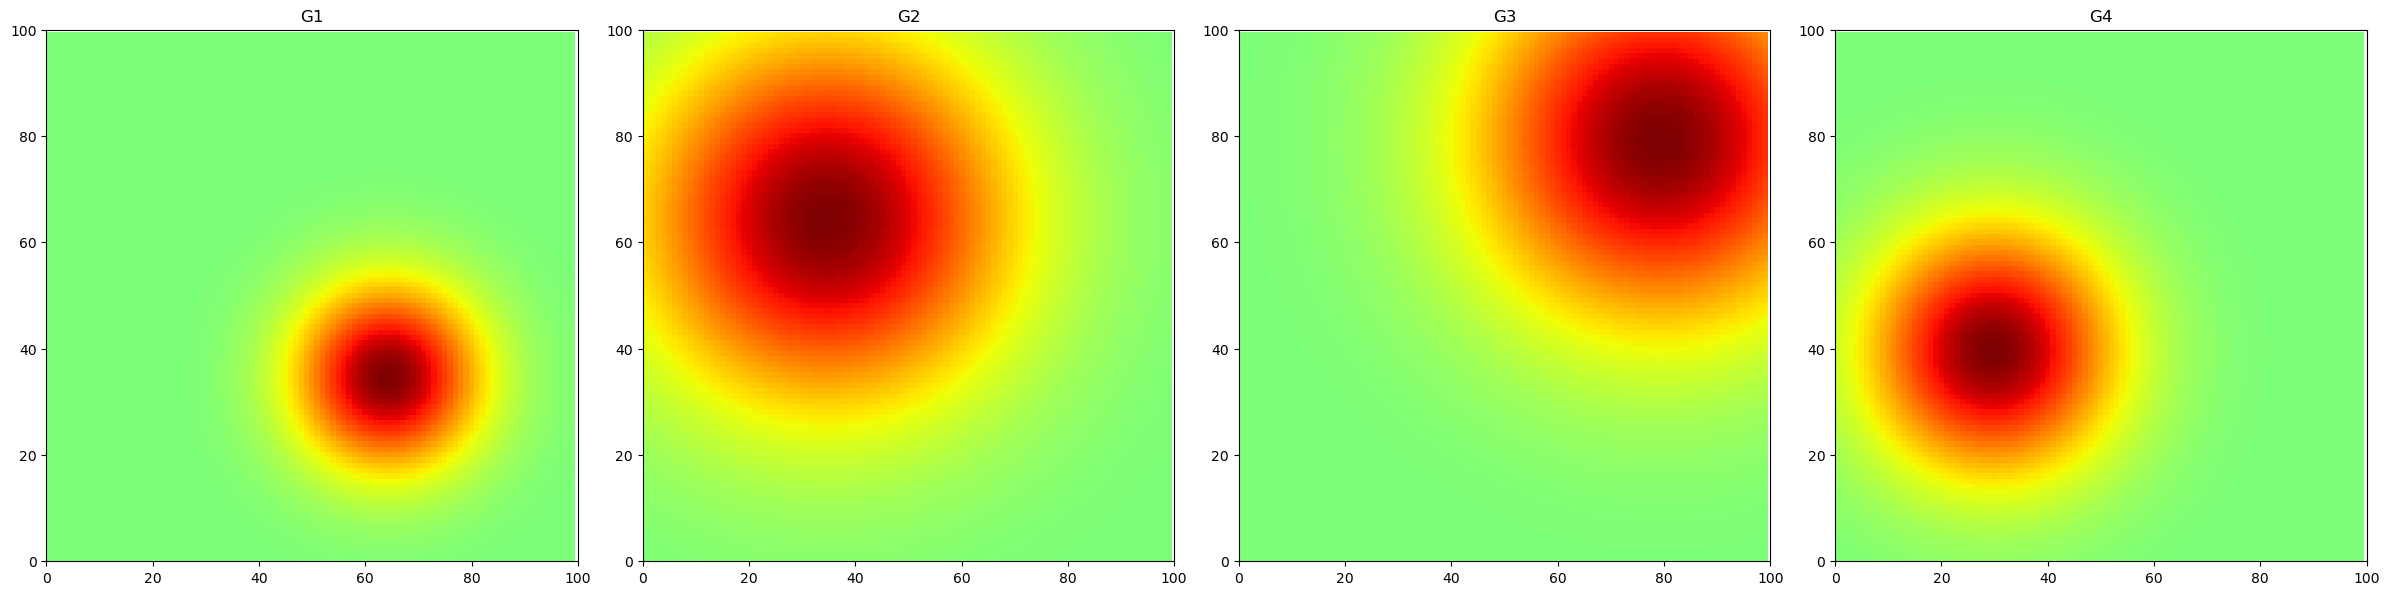

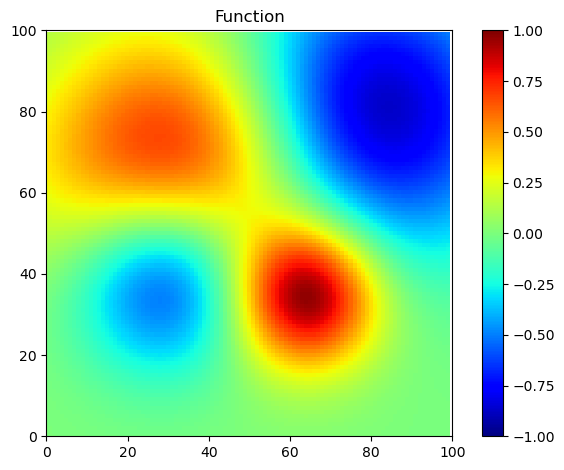

In [3]:
# Defining a grid of Xs and Ys
resolution = 100
X, Y = np.meshgrid( np.linspace(-1,1,resolution), np.linspace(-1,1,resolution) )

# Defining 4 different 2D functions
mux, muy, sigma = 0.3, -0.3, 4
G1 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)

mux, muy, sigma = -0.3, 0.3, 2
G2 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)

mux, muy, sigma = 0.6, 0.6, 2
G3 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)

mux ,muy, sigma = -0.4, -0.2, 3
G4 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)


# Composing the final function
G = G1 + G2 - G3 - G4


fig  = plt.figure(figsize=(6*4,6)) # Defining the figure space
axes = fig.subplots(1, 4)          # Defining the subplots in the figure

for ax, g, t in zip(axes.flat, [G1, G2, G3, G4], ['G1', 'G2', 'G3', 'G4']): # Iterating over axes and functions
    ax.imshow(g, vmin=-1, vmax=1, cmap='jet')                               # Ploting the function on the subplot
    ax.set(title=t, xlim=(0, 100), ylim=(0, 100))                           # Setting the title and limits of the subplot

fig.tight_layout() # Removes extra spacing from the figure

fig, ax = plt.subplots()

cax = ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
ax.set(title="Function", xlim=(0, 100), ylim=(0, 100))

fig.colorbar(cax) # Attaching the colorbar to the figure

fig.tight_layout() 
plt.show()               # Instruct Matplotlib to show the figures created

# fig.savefig("./assets/images/Optimization.png", dpi=300)

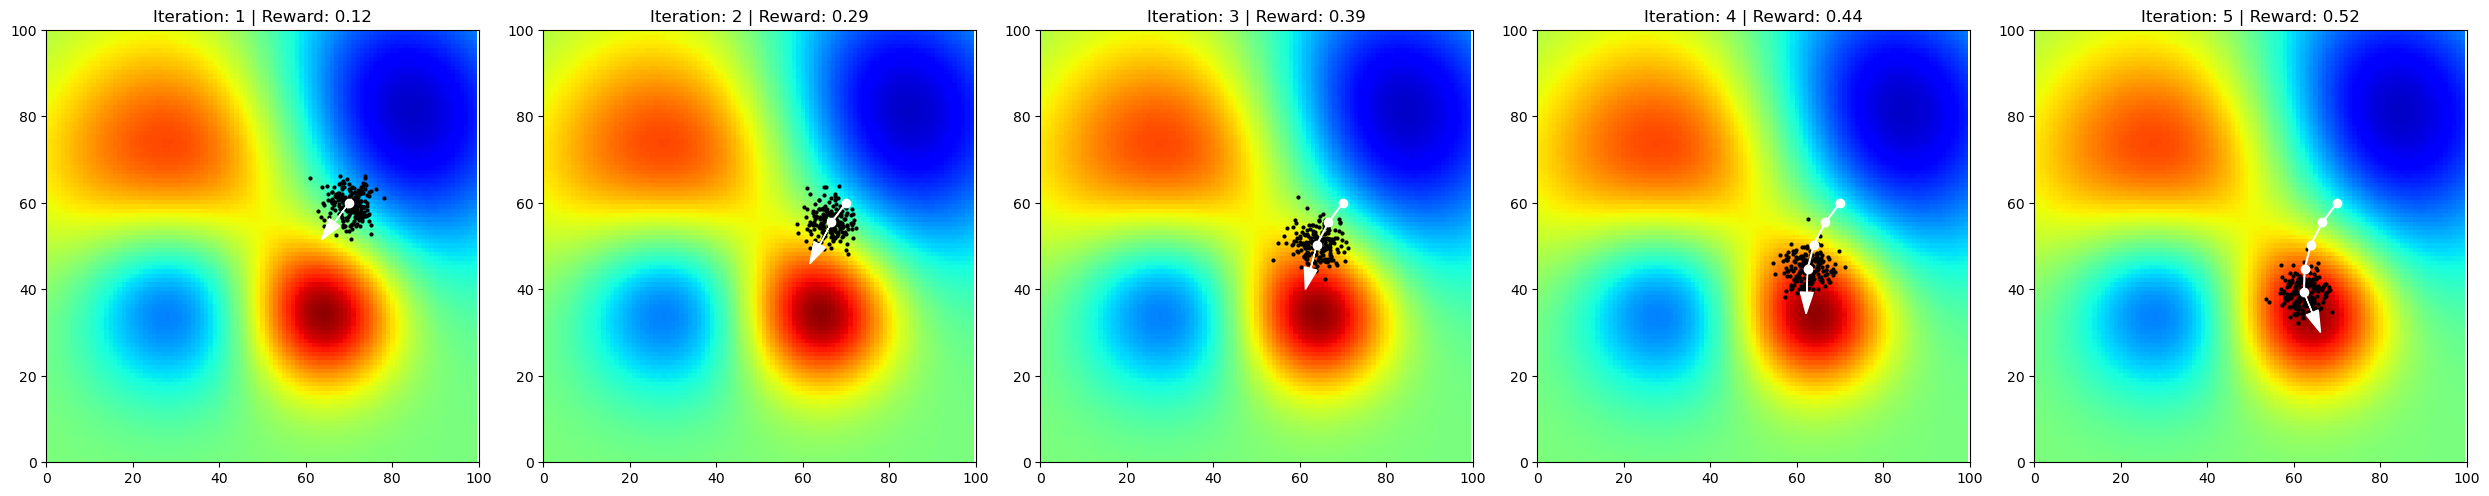

In [4]:
n_iter = 5     # Number of Steps to take for optimisation
alpha  = 0.03  # Learning rate of the optimisation

w = np.array([70.0, 60.0]) # Starting Parameter (Point)
sigma  = 3                 # Standard deviation of the samples around current parameter vector

fig  = plt.figure( figsize=(5*n_iter, 5) )
axes = fig.subplots(1, n_iter) 

prevx, prevy = [], []
for q, ax in zip(range(n_iter), axes):
    
    # Draw the Optimization Landscape
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')

    # Sample Random Population
    noise = np.random.randn(200, 2)
    wp = np.expand_dims(w, 0) + sigma * noise
    x,y = zip(*wp)
    
    # Estimate Gradient (Direction)
    R  = np.array([G[int(wi[1]), int(wi[0])] for wi in wp])
    R -= R.mean()
    R /= R.std() 
    g  = np.dot(R, noise)
    u  = alpha * g
    
    prevx.append(w[0])
    prevy.append(w[1])
    
    # Draw Population on Landscape (Black Points)
    ax.scatter(x, y, 4, 'k', edgecolors='face')
    
    # Draw estimated gradient (direction) as arrow (White Arrow)
    ax.arrow(w[0], w[1], u[0], u[1], head_width=3, head_length=5, fc='w', ec='w')
    
    # Draw Parameter History (White Points)
    ax.plot(prevx, prevy, 'wo-')
    
    # Update Parameter According to the gradient
    w += alpha * g
    
    ax.set(title=f"Iteration: {q+1} | Reward: {G[int(w[0]), int(w[1])]:.2f}", xlim=(0, 100), ylim=(0, 100))

fig.tight_layout()

In [5]:
class Value:
    def __init__(self, data, label='', _children=(), _op=''):
        
        # Information about value, gradient and its name
        self.data  = data
        self.grad  = 0.0
        self.label = label
        
        # Utility attributes for the calculating and passing gradients (Backprop)
        self._backward = lambda: None
        self._prev     = set(_children)
        self._op       = _op 
    
    # Simple arithemtic operations on value and computing corresponding gradients   
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, label='+', _children=(self, other), _op='+')

        def _backward():
            self.grad  += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, label='*', _children=(self, other), _op='*')

        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data  * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, label=f'**{other}', _children=(self,), _op='**')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    # Other arithmetic operations
    ### Don't need to define backward functions since, they use __mul__ or __add__ for which backward is already defined. 
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    # Simple transformations on Value and computing corresponding gradients
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, label='ReLU', _children=(self,), _op='ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
        out = Value(t, label='Tanh', _children=(self, ), _op='Tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
  
    def exp(self):
        x = self.data
        out = Value(np.exp(x), label='Exp',  _children=(self, ), _op='Exp')
        
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        
        return out
    
    # Information when printing instance
    def __repr__(self):
        if self.label:
            return f"Value(node={self.label}, data={self.data}, grad={self.grad})"
        else:
            return f"Value(data={self.data}, grad={self.grad})"
    
    # Recurisvely call backward -> Backprop
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [6]:
# Builds the graph from a root node
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

# Visualizes the graph built from root node
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [7]:
def cost_function(x):
    return x**2 - 4*x + 3 

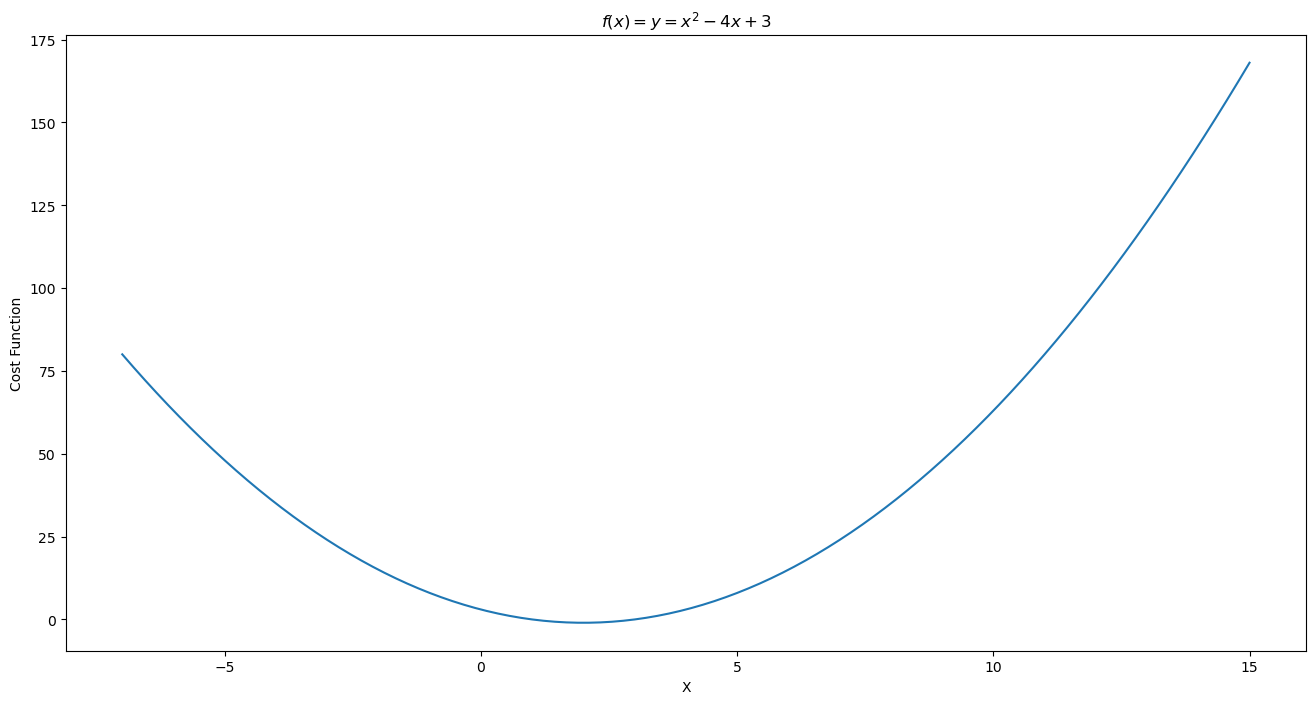

In [8]:
X = np.linspace(-7, 15, 100)
Y = cost_function(X)

fig = plt.figure(figsize=(16, 8))
ax  = fig.subplots()

ax.plot(X, Y)

ax.set(xlabel='X', ylabel='Cost Function', title=f"$f(x) = y = x^2 - 4x + 3$")

plt.show()

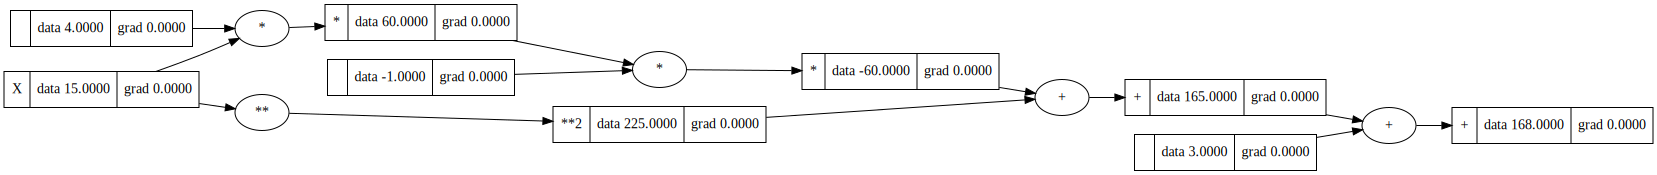

In [9]:
x = Value(15.0, label='X')
y = cost_function(x)

draw_dot(y)

In [10]:
y.backward()
x

Value(node=X, data=15.0, grad=26.0)

Step:  1 | X: 15.00 | f(X): 168.0000 | Gradient dy/dx: 26.0000
Step:  2 | X: 12.40 | f(X): 107.1600 | Gradient dy/dx: 20.8000
Step:  3 | X: 10.32 | f(X):  68.2224 | Gradient dy/dx: 16.6400
Step:  4 | X:  8.66 | f(X):  43.3023 | Gradient dy/dx: 13.3120
Step:  5 | X:  7.32 | f(X):  27.3535 | Gradient dy/dx: 10.6496
Step:  6 | X:  6.26 | f(X):  17.1462 | Gradient dy/dx:  8.5197
Step:  7 | X:  5.41 | f(X):  10.6136 | Gradient dy/dx:  6.8157
Step:  8 | X:  4.73 | f(X):   6.4327 | Gradient dy/dx:  5.4526
Step:  9 | X:  4.18 | f(X):   3.7569 | Gradient dy/dx:  4.3621
Step: 10 | X:  3.74 | f(X):   2.0444 | Gradient dy/dx:  3.4897

----------------------------------------------------------------------



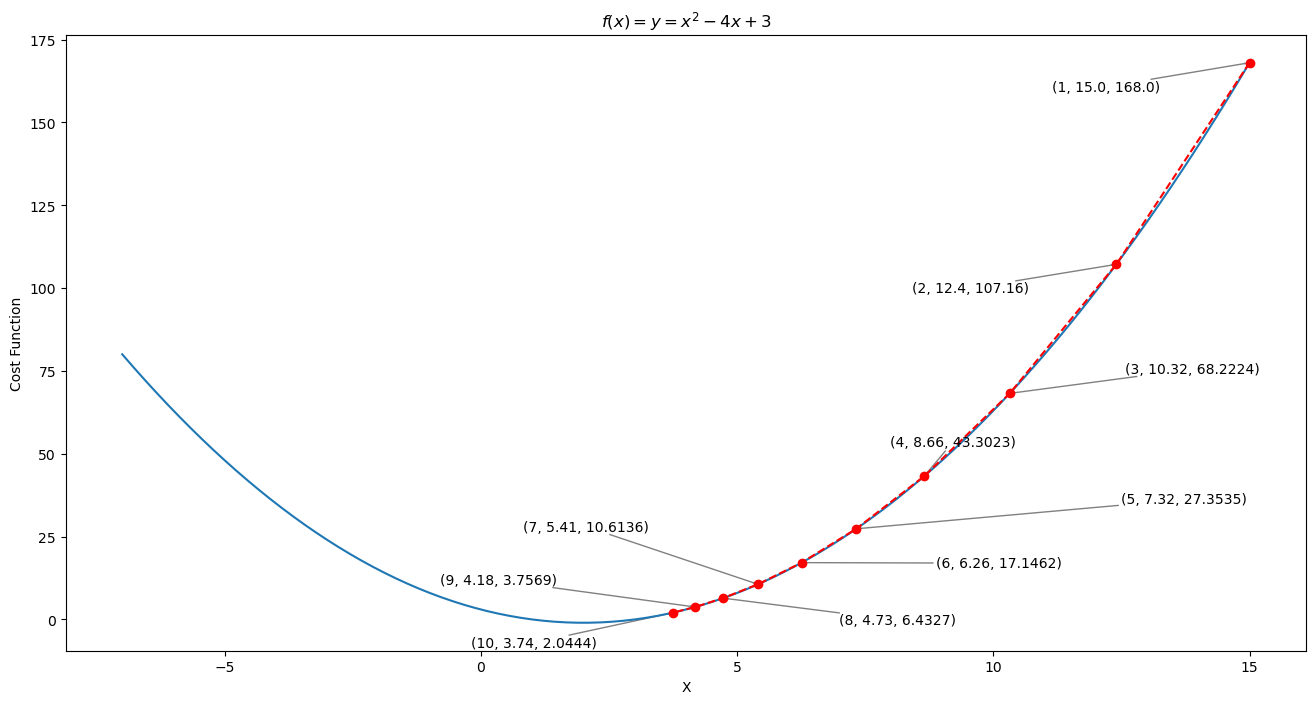

In [11]:
alpha = 0.1 # 0.1 # 0.3 # 0.9 #
num_iterations = 10

x = Value(15.0, label='X')

xy_list = []
for i in range(num_iterations):
    
    # Calculate f(x)
    y = cost_function(x)
    
    # Calculate dy/dx
    y.backward()
    
    xy_list.append((x.data, y.data))
    print(f"Step: {i+1:2d} | X: {x.data:5.2f} | f(X): {y.data:8.4f} | Gradient dy/dx: {x.grad:7.4f}")
    
    # Update x 
    x -= alpha * x.grad

print(f"\n{'-'*70}\n")

xy_list = np.asarray(xy_list)

ax.plot(xy_list[:, 0], xy_list[:, 1], 'r--', marker="o")

texts = []
for i in range(len(xy_list)):
    text = ax.text(*xy_list[i], f"({i+1}, {round(xy_list[i, 0], 2)}, {round(xy_list[i, 1], 4)})", ha='center', va='center')
    texts.append(text)
adjust_text(texts, expand=(3, 3.5), arrowprops=dict(arrowstyle='->', color='grey'), ax=ax)

fig

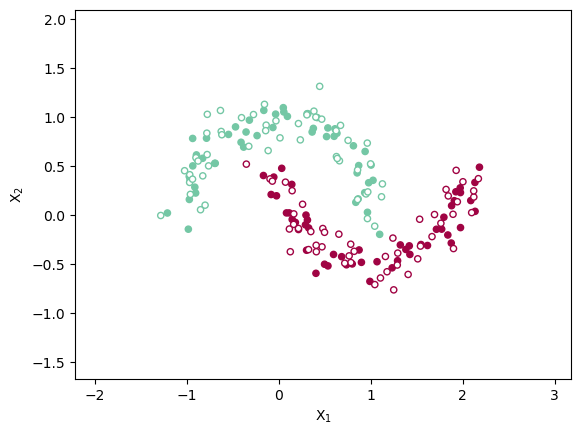

In [12]:
X_train, y_train = datasets.make_moons(n_samples=100, noise=0.1)
X_test,  y_test  = datasets.make_moons(n_samples=100, noise=0.15)

# make y be -1 or 1
y_train = y_train*2 - 1 
y_test  = y_test*2 - 1
 
cmap = plt.cm.Spectral

fig, ax = plt.subplots()

ax.scatter(X_train[:,0], X_train[:,1], c=[cmap(i%200) for i in y_train],               s=20)
ax.scatter(X_test[:,0],  X_test[:,1],  edgecolor=[cmap(i%200) for i in y_test], c='w', s=20)

ax.set(xlabel="X$_1$", ylabel="X$_2$", xlim =(X_train[:, 0].min()-1, X_train[:, 0].max()+1), ylim=(X_train[:, 1].min()-1, X_train[:, 1].max()+1))
plt.show()

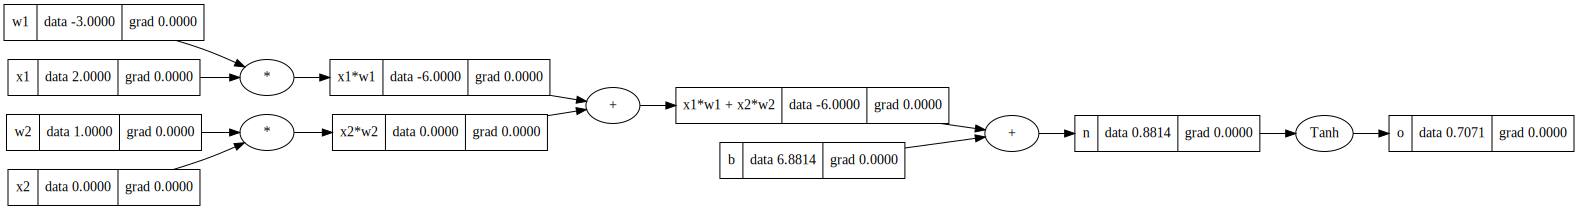

In [13]:
# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

draw_dot(o)

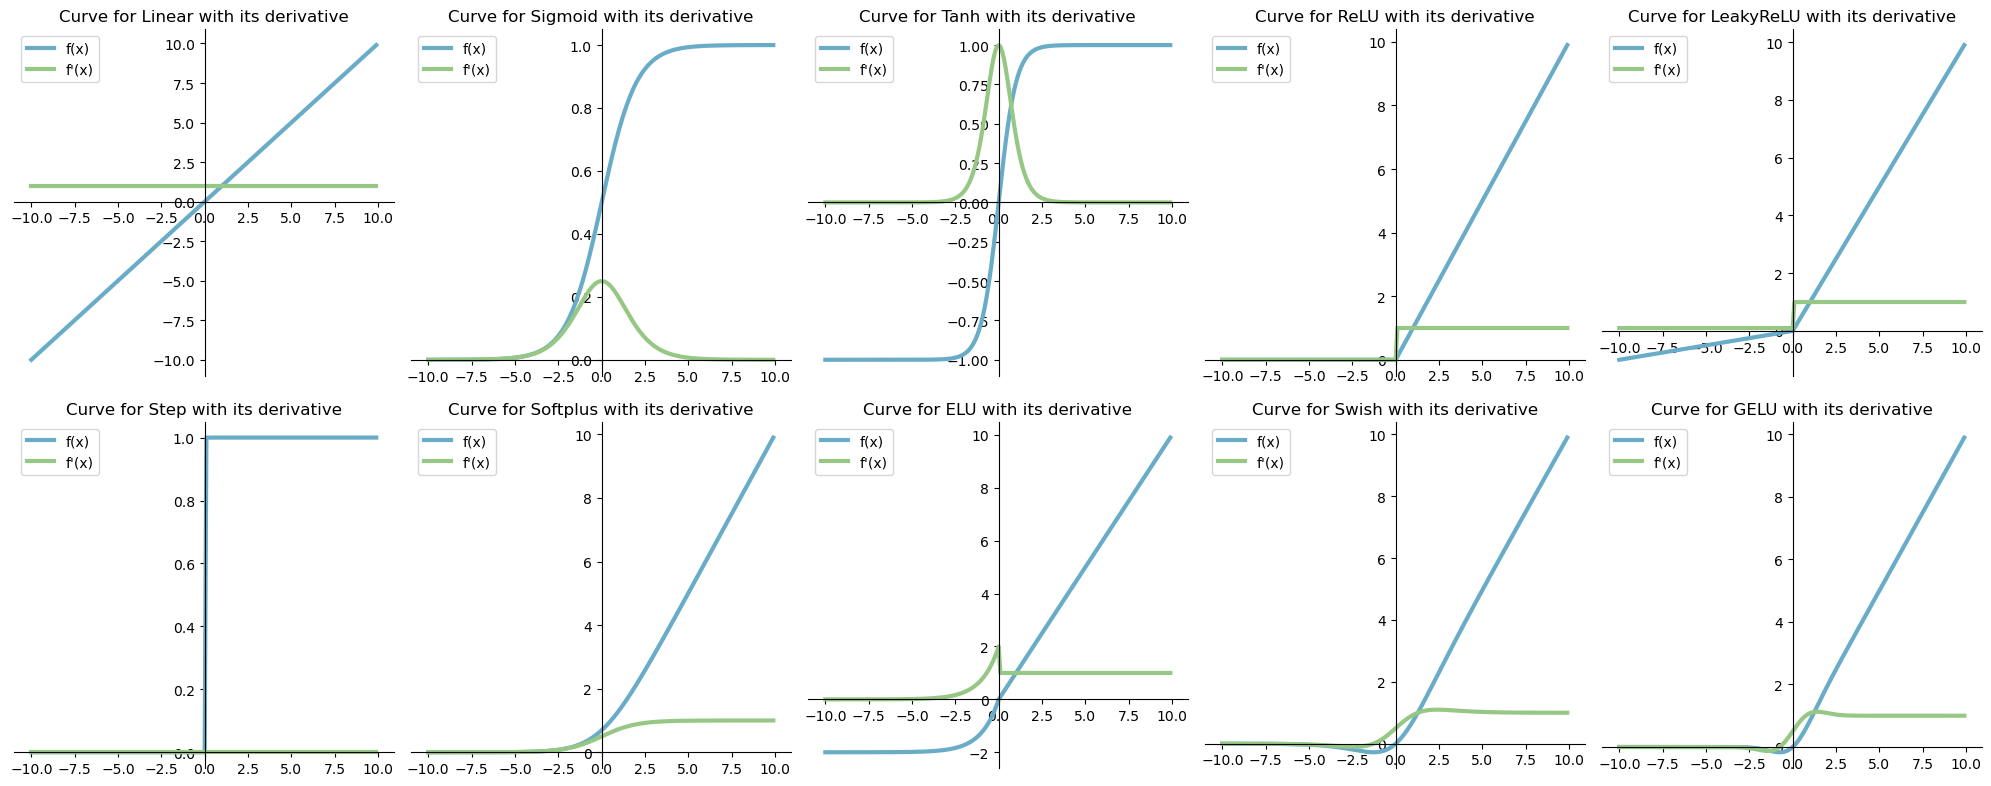

In [14]:
def plot(x, y, dy, title, ax):
    ax.plot(x, y, linewidth=3, label="f(x)", color="#69acc7")
    ax.plot(x, dy, linewidth=3, label="f'(x)", color="#97c784")
    ax.set_title(f"Curve for {title} with its derivative")
    ax.legend(loc='best')
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

from scipy.special import erf

fig = plt.figure(figsize=(4*5, 4*2))
axes = fig.subplots(2, 5)

x = np.arange(-10, 10, 0.1)

y  = x 
dy = np.ones_like(x)
plot(x, y, dy, 'Linear', axes[0, 0])

y  = 1/(1+np.exp(-x)) 
dy = y*(1-y)
plot(x, y, dy, 'Sigmoid', axes[0, 1])

y  = (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x)) 
dy = 1-(y**2)
plot(x, y, dy, 'Tanh', axes[0, 2])

y  = np.maximum(x, 0) 
dy = np.heaviside(x,1) 
plot(x, y, dy, 'ReLU', axes[0, 3])

alpha = 0.1
y  = np.where(x<0, alpha*x, x)
dy = np.where(x<0, alpha,   1)
plot(x, y, dy, 'LeakyReLU', axes[0, 4])

y  = np.heaviside(x,1) 
dy = np.zeros_like(y)
plot(x, y, dy, 'Step', axes[1, 0])

y  = np.log(1+np.exp(x))
dy = 1/(1+np.exp(-x))
plot(x, y, dy, 'Softplus', axes[1, 1])

alpha = 2
y  = np.where(x<=0, alpha*(np.exp(x)-1), x)
dy = np.where(x<=0, alpha*np.exp(x), 1)
plot(x, y, dy, 'ELU', axes[1, 2])

f = 1 + np.exp(-x)
y  = x/f
dy = (f + (x*np.exp(-x)))/(f**2)
plot(x, y, dy, 'Swish', axes[1, 3])

s = x / np.sqrt(2)
erf_prime = lambda x: (2 / np.sqrt(np.pi)) * np.exp(-(x ** 2))
y  = 0.5 * x * (1 + erf(s))
dy = 0.5 + 0.5 * erf(s) + ((0.5 * x * erf_prime(s)) / np.sqrt(2))
plot(x, y, dy, 'GELU', axes[1, 4])


fig.tight_layout()
plt.show()

In [15]:
class Module:

    # Explictly make gradients 0.0
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0

    # List of Parameters
    def parameters(self):
        return []

class Neuron(Module):

    # Initialises weights, bias and activations for the neuron
    def __init__(self, nin, activation='ReLU', layer_name='', neuron_name=''):
        
        self.w = [Value(np.random.uniform(-1,1), label=f"Weight of {layer_name} {neuron_name} for Input {i+1}") for i in range(nin)]
        self.b = Value(0, label=f"Bias of {layer_name} {neuron_name}")
        self.activation = activation

    # Sets the list of parameters in the neuron
    def parameters(self):
        return self.w + [self.b]

    # Information when printing neuron
    def __repr__(self):
        return f"{self.activation}Neuron(nin={len(self.w)})"
    
    # Forward Pass -> Compute the output of the neuron
    def __call__(self, x):
        
        # Weighted Sum
        w = sum((wi*xi for wi,xi in zip(self.w, x)))
        
        # Add the bias
        out = w + self.b
        
        # Activation Function is applied
        if self.activation == 'ReLU':
            out = out.relu()
        elif self.activation == 'Tanh':
            out = out.tanh()
        elif self.activation == 'Linear':
            out = out
            
        # Output of Neuron
        return out

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        # Define neurons of a layer
        self.neurons = [Neuron(nin, neuron_name=f"Neuron {i+1}", **kwargs) for i in range(nout)]

    # Sets the list of parameters in the layer
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    # Information when printing layer
    def __repr__(self):
        return f"Layer of [ {', '.join(str(n) for n in self.neurons)} ]"
    
    # Forward Pass -> Compute the output of the layer
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

class MLP(Module):

    def __init__(self, nin, nouts, activations=None):
        if activations is not None:
            assert len(nouts) == len(activations), 'Activations not defined for some layers'
        else:
            activations = ['Linear'] * len(nouts)
            
        sz = [nin] + nouts 
        
        # Define layers of a MLP
        self.layers = [Layer(sz[i], sz[i+1], activation=activations[i], layer_name=f"Layer {i+1}") for i in range(len(nouts))]

    # Sets the list of parameters in the MLP
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    # Information when printing MLP
    def __repr__(self):
        new_line = f"\n{'-'*8}> "
        return f"MLP of [{new_line}{new_line.join(str(layer) for layer in self.layers)}\n]"
    
    # Forward Pass -> Compute the output of the MLP
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [16]:
def compute_loss(model, batch_size=None, X=X_train, y=y_train):
    
    # Process Data in batches, in case data is too big to handle
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    # Format Data to our Datatype
    inputs = [ [Value(xrow[0], label='X'), Value(xrow[1], label='Y')] for xrow in Xb]
    
    # Forward Pass to get the scores
    scores = list(map(model, inputs))
    
    # Max-Margin Loss to calculate fitness based on scores and y
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    output_loss = sum(losses) * (1.0 / len(losses))
    
    # L2 Regularization (Optional)
    ## To improve performance, we also regularise the parameters. 
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    
    # Compute Final Loss -> Max-Margin Loss + L2 Regularization Loss
    loss = output_loss + reg_loss
    
    # Compute Predictions and Accuracy
    predictions = np.array([1 if (scorei.data > 0) else -1 for scorei in scores])
    accuracy    = sum([(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)])/len(yb)
    
    # Return everything required
    data = {}
    data['loss']        = loss
    data['scores']      = scores
    data['predictions'] = predictions
    data['accuracy']    = 100*accuracy
    return data

In [17]:
model = MLP(nin=2, nouts=[2, 2, 1]) # 2-layer neural network
print(model)
print(f"Number of Parameters: {len(model.parameters())}")

MLP of [
--------> Layer of [ LinearNeuron(nin=2), LinearNeuron(nin=2) ]
--------> Layer of [ LinearNeuron(nin=2), LinearNeuron(nin=2) ]
--------> Layer of [ LinearNeuron(nin=2) ]
]
Number of Parameters: 15


In [18]:
data = compute_loss(model)
print(f"Loss: {data['loss'].data:.4f} | Accuracy: {data['accuracy']: 5.2f}%")

Loss: 0.9772 | Accuracy:  65.00%


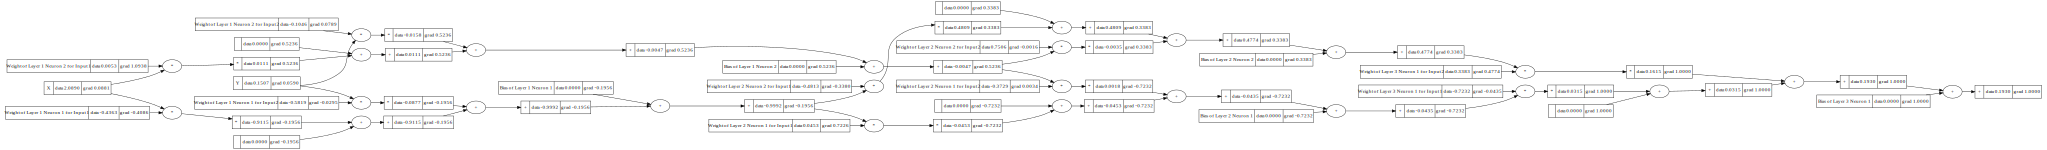

In [19]:
data['scores'][0].backward()
draw_dot(data['scores'][0])

In [20]:
n_iter = 20
n_log  = 1
learning_rate = lr = 1.0

model = MLP(nin=2, nouts=[16, 16, 1], activations=['ReLU', 'ReLU', 'Linear']) # 2-layer neural network
print(model)
print(f"Number of Parameters: {len(model.parameters())}")
print(f"\n{'-'*70}\n")
train_history = []

# Optimize Iteratively
for k in range(n_iter):
    
    # Zero-Grad
    model.zero_grad()

    # Forward Pass -> Compute Loss
    data = compute_loss(model)
    
    # Backward Pass
    data['loss'].backward()
        
    # Log Details
    if k % n_log == 0:
        print(f"Step: {k+1:3d} | Loss: {data['loss'].data:.4f} | Accuracy: {data['accuracy']:5.2f}% | Learning Rate: {lr:.2f}")
        train_history.append((data['loss'].data, data['accuracy'], lr))
    
    # Update Weights using SGD
    lr = learning_rate - 0.9*(k+1)/n_iter
    for p in model.parameters():
        p.data -= lr * p.grad
    

MLP of [
--------> Layer of [ ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2), ReLUNeuron(nin=2) ]
--------> Layer of [ ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16), ReLUNeuron(nin=16) ]
--------> Layer of [ LinearNeuron(nin=16) ]
]
Number of Parameters: 337

----------------------------------------------------------------------

Step:   1 | Loss: 0.5211 | Accuracy: 72.00% | Learning Rate: 1.00
Step:   2 | Loss: 0.6846 | Accuracy: 75.00% | Learning Rate: 0.95
Step:   3 | Loss: 1.7811 | Accuracy: 78.00% | 

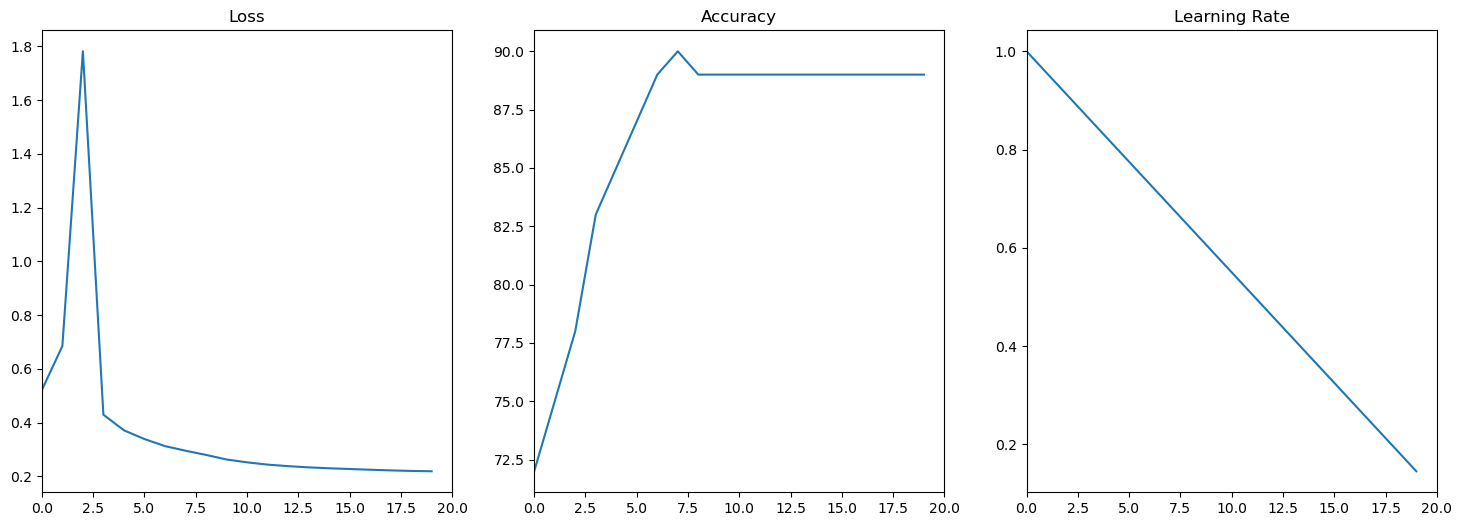

In [21]:
fig = plt.figure(figsize=(6*3, 6))
axes = fig.subplots(1, 3)

train_history = np.asarray(train_history)

for ax, d, t in zip(axes.flat, [train_history[:, 0], train_history[:, 1], train_history[:, 2]], ['Loss', 'Accuracy', 'Learning Rate']):
    ax.plot(d)
    ax.set(title=t, xlim=(0, n_iter))

plt.show()

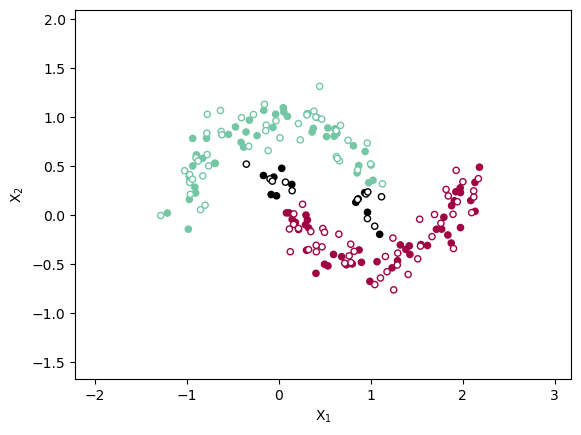

In [22]:
train_data = compute_loss(model, X=X_train, y=y_train)
test_data  = compute_loss(model, X=X_test,  y=y_test)

cmap = plt.cm.Spectral
fig, ax = plt.subplots()

train_color = [cmap(j%200) if i==j else 'k' for i, j in zip(train_data['predictions'], y_train)]
test_color  = [cmap(j%200) if i==j else 'k' for i, j in zip(test_data['predictions'],  y_test)]

ax.scatter(X_train[:,0], X_train[:,1], c=train_color,                s=20)
ax.scatter(X_test[:,0],  X_test[:,1],  edgecolor=test_color, c='w',  s=20)

ax.set(xlabel="X$_1$", ylabel="X$_2$", xlim =(X_train[:, 0].min()-1, X_train[:, 0].max()+1), ylim=(X_train[:, 1].min()-1, X_train[:, 1].max()+1))
plt.show()

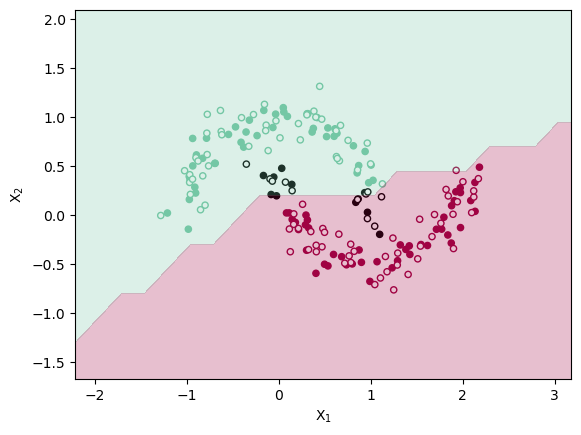

In [23]:
# Visualise Decision Boundary
resolution = 0.25
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1 
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1 

xx, yy = np.meshgrid(np.arange(x_min, x_max+ resolution, resolution), np.arange(y_min, y_max+ resolution, resolution))

Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]

scores = list(map(model, inputs))

Z = np.array([s.data > 0 for s in scores]).reshape(xx.shape)

ax.contourf(xx, yy, Z, colors=[cmap(-1%200), cmap(1)], alpha=0.25)

fig

In [24]:
%pip install torch==2.2.0 torchvision

Note: you may need to restart the kernel to use updated packages.


In [25]:
import os
import numpy as np
from tqdm.auto import tqdm
from itertools import repeat
from matplotlib import pyplot as plt
from matplotlib import offsetbox

from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler

import torch
import torchvision
import torch.nn.functional as F
from torch import nn as nn, optim as optim
from torchvision import datasets as tdatasets, transforms, utils as vutils

torch.manual_seed(1337)
device = 'cpu' if torch.cuda.is_available() else 'cuda'

out_dir = 'out'
os.makedirs(out_dir, exist_ok=True)

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)
        

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [27]:
batch_size      = 128
test_batch_size = 512

train_kwargs = {'batch_size': batch_size}
test_kwargs  = {'batch_size': test_batch_size}

def infinite_loader(data_loader):
    for loader in repeat(data_loader):
        for data in loader:
            yield data
            
train_dataset = tdatasets.MNIST('../data', train=True,  download=True, transform=transforms.ToTensor())
test_dataset  = tdatasets.MNIST('../data', train=False, transform=transforms.ToTensor())
train_loader  = infinite_loader(torch.utils.data.DataLoader(train_dataset,**train_kwargs))
test_loader   = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

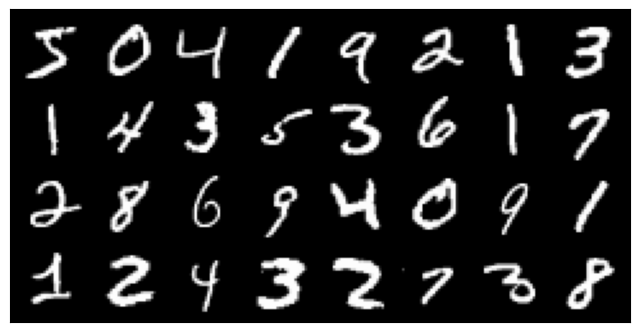

In [28]:
batch = next(iter(train_loader))

fig = plt.figure(figsize=(8, 8))
ax = fig.subplots()

ax.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:32], padding=2, normalize=True).cpu(), (1,2,0)))
ax.set(xticks=[], yticks=[])
plt.show()

In [29]:
n_iter          = 1000
learning_rate   = 0.1
n_log           = 1

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0.01, T_max=n_iter)

model

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [30]:
def train(model, device, train_loader, optimizer, scheduler, n_iter):
    train_history = []
    model.train()
    with tqdm(total=n_iter) as bar:
        for batch_idx, (data, target) in enumerate(train_loader):
            
            # Converting data to required format
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 784)
            
            # Explictily Zeroing Gradients
            optimizer.zero_grad()
            
            # Forward Pass
            output = model(data)
            
            # Calculate Loss
            loss = F.nll_loss(output, target)
            
            # Backward Pass
            loss.backward()
            
            # Updating Weights
            optimizer.step()
            
            if batch_idx % n_log == 0:
                bar.update(n_log)
                bar.set_postfix({'Loss':  f"{loss.item():.4f}", 'Learning Rate': f"{scheduler.get_last_lr()[0]:.4f}"})
                train_history.append((loss.item, scheduler.get_last_lr()[0]))
            
            # Changing Learning Rate
            scheduler.step()
            
            if batch_idx == n_iter-1:
                break

def test(model, device, test_loader):
    model.eval()
    
    test_loss = 0
    correct   = 0
    
    images    = []
    labels    = []
    outputs   = []
    
    with torch.no_grad() and tqdm(total=len(test_loader)) as bar:
        for data, target in test_loader:
            
            # Converting data to required format
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 784)
            
            # Forward Pass
            output = model(data)
            
            # Calculate Loss
            loss = F.nll_loss(output, target, reduction='sum').item()  
            
            # Get Prediction
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            correct   += pred.eq(target.view_as(pred)).sum().item()
            test_loss += loss
            outputs.extend(output.detach().cpu().numpy())
            images.extend(data.detach().cpu().numpy())
            labels.extend(target.detach().cpu().numpy())
            
            bar.update(1)

    test_loss /= len(test_loader.dataset)
    correct   /= len(test_loader.dataset)
    images      = np.asarray(images).reshape(-1, 1, 28, 28).transpose(0, 2, 3, 1)
    labels      = np.asarray(labels)
    outputs     = np.asarray(outputs)

    print(f"Test set--- Average loss: {test_loss:.4f}, Accuracy: {100. * correct:.2f}%")
    return images, labels, outputs

In [31]:
train(model, device, train_loader, optimizer, scheduler, n_iter)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
torch.jit.script(model).save(os.path.join(out_dir, 'mnist-ckpt.pt'))

In [33]:
trained_model = torch.jit.load(os.path.join(out_dir, 'mnist-ckpt.pt'))

In [34]:
images, labels, outputs = test(trained_model, device, test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Test set--- Average loss: 0.2555, Accuracy: 92.52%


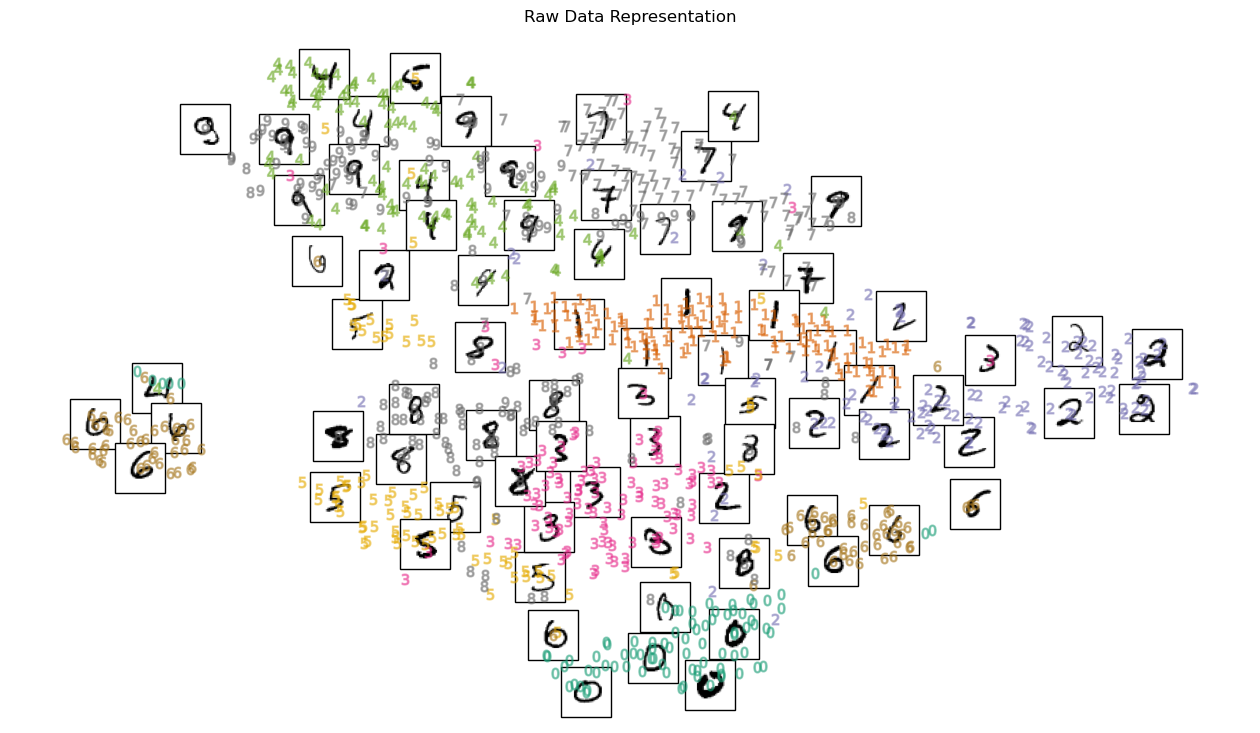

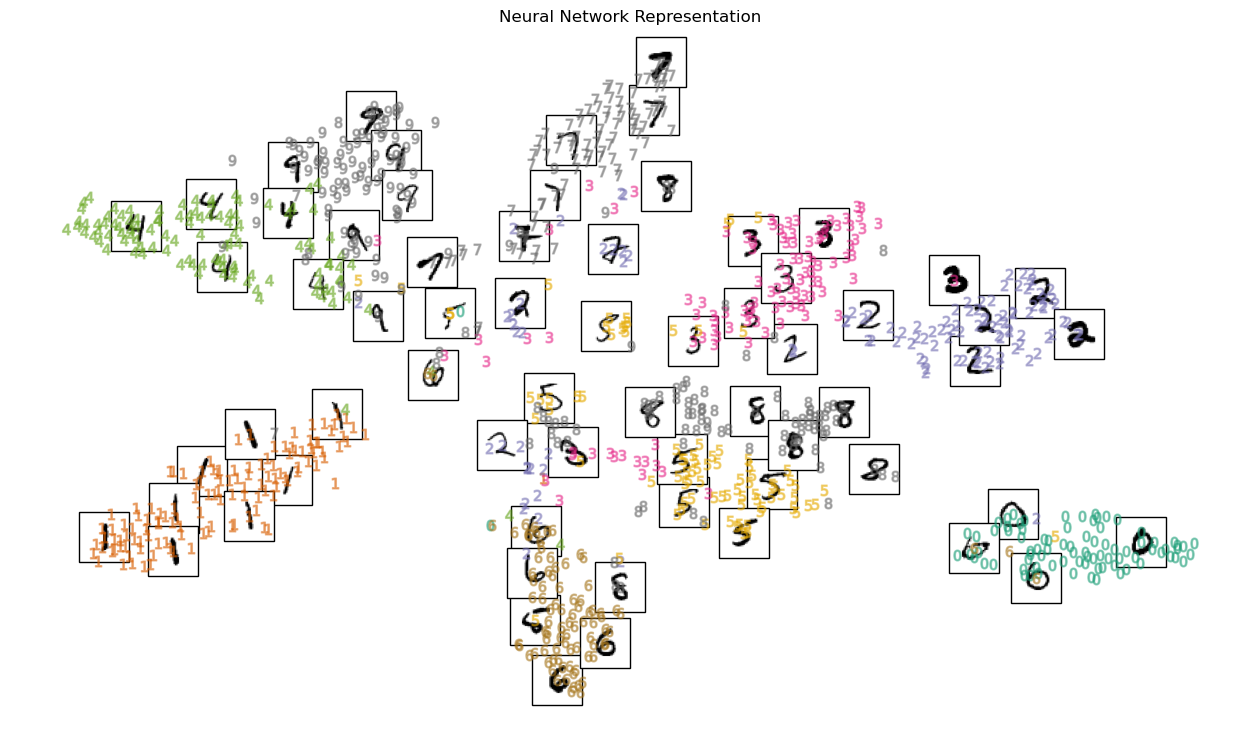

In [35]:
def plot_embedding(embedding, images, labels, title):
    fig = plt.figure(figsize=(16, 9))
    ax  = fig.subplots()
    
    X = MinMaxScaler().fit_transform(embedding)
    
    for digit in range(10):
        ax.scatter(*X[labels == digit].T, marker=f"${digit}$", s=60, color=plt.cm.Dark2(digit), alpha=0.425, zorder=2,)
    
    shown_images = np.array([[1.0, 1.0]])
    for i in range(X.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r), X[i])
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

num_images = 1000

tsne = manifold.TSNE(n_components=2)

image_embedding = tsne.fit_transform(images[:num_images].reshape(num_images, -1), labels[:num_images])
plot_embedding(image_embedding, images[:num_images], labels[:num_images], "Raw Data Representation")

output_embedding = tsne.fit_transform(outputs[:num_images].reshape(num_images, -1), labels[:num_images])
plot_embedding(output_embedding, images[:num_images], labels[:num_images], "Neural Network Representation")

In [36]:
%pip install torch==2.2.0
%pip install transformers
%pip install datasets
%pip install tiktoken

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [37]:
import os
import numpy as np
import math 
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange
from contextlib import nullcontext

import requests
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

import tiktoken

In [38]:
torch.manual_seed(1337)
torch.backends.cuda.matmul.allow_tf32 = True 
torch.backends.cudnn.allow_tf32 = True 

device_type = device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler

ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

out_dir = './'
os.makedirs(out_dir, exist_ok=True)

if device == 'cuda':
    torch.cuda.empty_cache()

In [39]:
data_dir = './'
input_file_path = os.path.join(data_dir, 'input.txt')

if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)
        
with open(input_file_path, 'r', encoding='utf-8') as f:
    data = f.read()
    
print(data[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [40]:
 n = len(data)

train_data = data[:int(n*0.9)]
val_data   = data[int(n*0.9):]

In [41]:
enc = tiktoken.get_encoding("gpt2")
vocab_size = 50304 # Rounded to closest power of 64

In [42]:
phrase = "Hello World"
print(f"Phrase: {phrase:20s} {enc.encode_ordinary(phrase)}")

Phrase: Hello World          [15496, 2159]


In [43]:
phrase = "Skip Skips Skipped"
print(f"Phrase: {phrase:20s} {enc.encode_ordinary(phrase)}")

phrase = "Laugh Laughs Laughed"
print(f"Phrase: {phrase:20s} {enc.encode_ordinary(phrase)}")

Phrase: Skip Skips Skipped   [50232, 3661, 2419, 3661, 3949]
Phrase: Laugh Laughs Laughed [43, 1567, 406, 19256, 406, 13726]


In [44]:
class Char2Int:
    
    def __init__(self, data):
        chars = sorted(list(set(data)))
        self.vocab_size = len(chars)
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
    
    def encode_ordinary(self, s):
        return [self.stoi[c] for c in s]

    def decode(self, s):
        return ''.join([self.itos[i] for i in s])

enc = Char2Int(data)  
vocab_size = enc.vocab_size

In [45]:
phrase = "Hello World"
print(f"Phrase: {phrase:20s} {enc.encode_ordinary(phrase)}")

phrase = "Skip Skips Skipped"
print(f"Phrase: {phrase:20s} {enc.encode_ordinary(phrase)}")

phrase = "Laugh Laughs Laughed"
print(f"Phrase: {phrase:20s} {enc.encode_ordinary(phrase)}")

Phrase: Hello World          [20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42]
Phrase: Skip Skips Skipped   [31, 49, 47, 54, 1, 31, 49, 47, 54, 57, 1, 31, 49, 47, 54, 54, 43, 42]
Phrase: Laugh Laughs Laughed [24, 39, 59, 45, 46, 1, 24, 39, 59, 45, 46, 57, 1, 24, 39, 59, 45, 46, 43, 42]


In [46]:
train_ids = enc.encode_ordinary(train_data)
val_ids   = enc.encode_ordinary(val_data)

print(f"Train Split has {len(train_ids):,} tokens")
print(f"Val Split has {len(val_ids):,} tokens")
print(f"Encoding Vocabulary Size is {vocab_size}")

train_ids = np.array(train_ids, dtype=np.uint16)
val_ids   = np.array(val_ids, dtype=np.uint16)

train_ids.tofile(os.path.join(data_dir, 'train.bin'))
val_ids.tofile(os.path.join(data_dir, 'val.bin'))

Train Split has 1,003,853 tokens
Val Split has 111,540 tokens
Encoding Vocabulary Size is 65


In [47]:
batch_size = 64
block_size = 256

print(f"Tokens per iteration will be: {batch_size * block_size}")

def get_batch(split):
    
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
        
    ix = torch.randint(len(data) - block_size, (batch_size,))
    
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64))     for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    
    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
        
    return x, y

Tokens per iteration will be: 16384


In [48]:
class LayerNorm(nn.Module):
    
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias   = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        
        self.n_head  = config.n_head
        self.n_embd  = config.n_embd
        self.dropout = config.dropout
        
        # Query, Key, Value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        
        # Regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        B, T, C = x.size() # Batch size, Sequence length, Embedding dimensionality (n_embd)

        # Calculate Query, Key, Values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # Causal Self-Attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        ### Efficient attention using Flash Attention CUDA kernels
        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        # Re-assemble all head outputs side by side
        y = y.transpose(1, 2).contiguous().view(B, T, C) 

        # Output projection
        y = self.resid_dropout(self.c_proj(y))
        
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp  = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        
        assert config.vocab_size is not None
        assert config.block_size is not None
        
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte  = nn.Embedding(config.vocab_size, config.n_embd),
            wpe  = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h    = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight 

        # Initialise all weights
        self.apply(self._init_weights)
        # Apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # Report Number of Parameters
        n_params = sum(p.numel() for p in self.parameters())
        n_params -= self.transformer.wpe.weight.numel()    
        print("Number of parameters: %.2fM" % (n_params/1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, idx, targets=None):
        
        device = idx.device
        
        b, t = idx.size()
        
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # Forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        
        x = self.transformer.drop(tok_emb + pos_emb)
        
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # If we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # Inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss   = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            
            # If the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]\
                
            # Forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            
            # Pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            
            # Optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            
            # Apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            
            # Append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int    = 12
    n_head: int     = 12
    n_embd: int     = 768
    dropout: float  = 0.0
    bias: bool      = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

In [49]:
n_layer = 6 
n_head  = 6 
n_embd  = 384 
bias    = False
dropout = 0.0

init_from = 'scratch' # 'scratch' or 'resume' 

model_args = dict(dropout=dropout)

if init_from == 'scratch':
    
    model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size, bias=bias, vocab_size=vocab_size)    

    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
    
    iteration     = 0
    best_val_loss = 1e9

elif init_from == 'resume':
    
    ckpt_path = os.path.join(out_dir, 'gpt-ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    
    checkpoint_model_args = checkpoint['model_args']
    for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
        model_args[k] = checkpoint_model_args[k]

    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
    
    state_dict = checkpoint['model']

    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
            
    model.load_state_dict(state_dict)
    
    iteration     = checkpoint['iteration']
    best_val_loss = checkpoint['best_val_loss']
    
model.to(device)

Number of parameters: 10.65M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(65, 384)
    (wpe): Embedding(256, 384)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=65, bias=False)
)

In [50]:
learning_rate = 1e-3
min_lr        = 1e-4           

warmup_iters   = 100      
lr_decay_iters = 5000  

# Leraning rate decay scheduler (cosine with warmup)
def get_lr(it):
    
    # 1) Linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    
    # 2) If it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    
    # 3) In between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + np.cos(np.pi * decay_ratio)) # coeff ranges 0..1
    
    return min_lr + coeff * (learning_rate - min_lr)

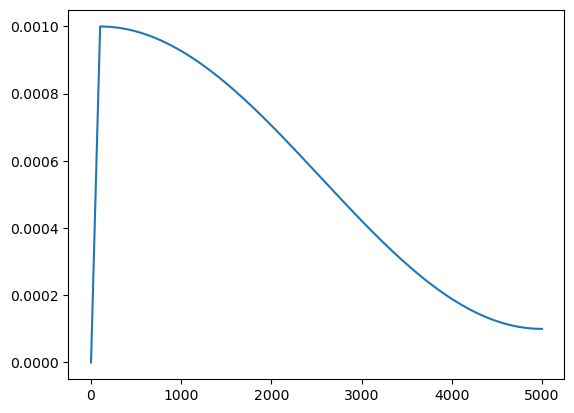

In [51]:
iter = np.linspace(0, 5000, 5000)
plt.plot(iter, [get_lr(x) for x in iter])
plt.show()

In [52]:
# Initialise a GradScaler.
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# Start with all of the candidate parameters
param_dict = {pn: p for pn, p in model.named_parameters() if p.requires_grad}

# Create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
# i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
decay_params   = [p for n, p in param_dict.items() if p.dim() >= 2]
nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
optim_groups = [
    {'params': decay_params,   'weight_decay': 0.1},
    {'params': nodecay_params, 'weight_decay': 0.0}
]

print(f"Num decayed parameter tensors: {len(decay_params)}, with {sum(p.numel() for p in decay_params)} parameters")
print(f"Num non-decayed parameter tensors: {len(nodecay_params)}, with {sum(p.numel() for p in nodecay_params)} parameters")

# Create AdamW optimizer and use the fused version if it is available
fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
use_fused = fused_available and device_type == 'cuda'

# Initialize an optimizer
extra_args = dict(fused=True) if use_fused else dict()
optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), **extra_args)
        
if init_from == 'resume':
    optimizer.load_state_dict(checkpoint['optimizer'])

# Compile the model
model = torch.compile(model)

# Free up memory
checkpoint = None 

Num decayed parameter tensors: 26, with 10740096 parameters
Num non-decayed parameter tensors: 13, with 4992 parameters


In [53]:
eval_iters = 200

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in tqdm(range(eval_iters), desc=split, leave=False, position=1):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [54]:
n_eval    = 250
n_log     = 10
n_iter    = 5000 # total number of training iterations
grad_clip = 0.0  # clip gradients at this value, or disable if == 0.0

# Converting data to required format
X, Y = get_batch('train')
         
with tqdm(total=n_iter, position=0) as bar:
    while True:

        # Explictily Zeroing Gradients
        optimizer.zero_grad(set_to_none=True)
        
        # Determine and set the learning rate for this iteration
        lr = get_lr(iteration)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        # Forward Pass            
        with ctx:
            logits, loss = model(X, Y)
        
        # Converting data to required format
        X, Y = get_batch('train')
                
        # Backward pass
        scaler.scale(loss).backward()
            
        # Gradient Clipping
        if grad_clip != 0.0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
        # Updating Weights
        scaler.step(optimizer)
        scaler.update()
        
        if iteration % n_log == 0:
            bar.update(n_log)
            bar.set_postfix({'Loss':  f"{loss.item():.4f}"})            
        
        # Evaluate the loss on train/val sets and write checkpoints
        if iteration % n_eval == 0 and iteration != 0:
            losses = estimate_loss()
            bar.set_description(f"Iteration: {iteration} | Train loss {losses['train']:.4f} | Val loss {losses['val']:.4f} | ")
            if losses['val'] < best_val_loss:
                best_val_loss = losses['val']
                if iteration > 0:
                    checkpoint = { 
                                  'model': model.state_dict(), 
                                  'optimizer': optimizer.state_dict(), 
                                  'model_args': model_args, 
                                  'iteration': iteration, 
                                  'best_val_loss': best_val_loss,
                                }
                    torch.save(checkpoint, os.path.join(out_dir, 'gpt-ckpt.pt'))
        
        iteration += 1
        
        # Termination of Training
        if iteration > n_iter:
            break 

  0%|          | 0/5000 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

val:   0%|          | 0/200 [00:00<?, ?it/s]

In [55]:
start = "\n"
start_ids = enc.encode_ordinary(start)
start_ids

[0]

In [56]:
num_samples    = 10
max_new_tokens = 500
temperature    = 0.8
top_k          = 200

x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

model.eval()
with ctx:
    for k in range(num_samples):
        y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        print(enc.decode(y[0].tolist()))
        print('---------------')



JULIET:
O, because that strike these wounds ere recounted
Mine express are to show their wailings;
But ten to their hearts, which stream of mine eyes,
My pity gentle to the east Henry the Fift.
Reach of Gloucester, found thy help's death;
For whom thou hast not, still thou strivest to get,
And what thou hast, forget'st not to dry knowledge,
For that it seems.

CAMILLO:
By on, he consents mtters me all.

LEONTES:
O, by this hasted with my last!
O my sword, to make the sea within thyself?
Ah, wha
---------------

Men plain is ashamed to you;
And ten you and young your father's bosom the vigourners,
And betwixt us to the graver sound with his teeth.

CLIFFORD:
You said so much before, and yet you fled.

WARWICK:
'Twas not your valour, Clifford, drove my tongue coward,
Is that set them on our name against the bishop's daughter.

NORTHUMBERLAND:
Be it with resolution then to fight.

CLIFFORD:
Ay, and follow me bury the seat,
Of these eyes such be past a conquerorery.

CATESBY:
My lord!

B

In [57]:
%pip install torch==2.2.0
%pip install git+https://github.com/RobustBench/robustbench.git 


Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-igpjd_52
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-igpjd_52
  Resolved https://github.com/RobustBench/robustbench.git to commit 391406affed13d824daf4f228fd50dfe619684be
  Preparing metadata (setup.py) ... done
  Using cached autoattack-0.1-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [58]:
%matplotlib inline
import numpy as np 
from matplotlib import pyplot as plt

from scipy.optimize import differential_evolution as de

import torch

from robustbench.data import load_cifar10
from robustbench.utils import load_model

from IPython import display

torch.manual_seed(1337)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    torch.cuda.empty_cache()

In [59]:
x_test, y_test = load_cifar10(n_examples=50)
model = load_model(model_name='Standard', dataset='cifar10', threat_model='Linf').to(device)
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Files already downloaded and verified


In [60]:
image_id = 10
image = x_test[image_id]
label = y_test[image_id]

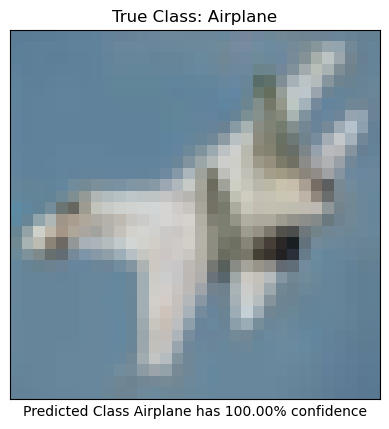

In [61]:
output = torch.softmax(model(image[None, ...].to(device)), dim=1)
conf, pred = output.max(dim=1)

fig = plt.figure()
ax = fig.subplots()
ax.imshow(image.permute(1,2,0))
ax.set(xticks=[], yticks=[], title=f"True Class: {classes[label]}", xlabel=f"Predicted Class {classes[pred.item()]} has {conf.item()*100:.2f}% confidence")
plt.show()

In [62]:
def perturb_image(perturbations, img):
    
    perturbations = perturbations.astype(int)
    if perturbations.ndim < 2:
        perturbations = np.array([perturbations])
    
    img = (img * 255).detach().cpu().numpy().astype(int)
    imgs = np.tile(img, [len(perturbations)] + [1]*(perturbations.ndim+1))
    
    for x, img in zip(perturbations, imgs):
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            x_pos, y_pos, *value = pixel
            img[:, round(x_pos), round(y_pos)] = value
        
    imgs = imgs/255.0
    imgs = torch.from_numpy(imgs).float()
    
    return imgs

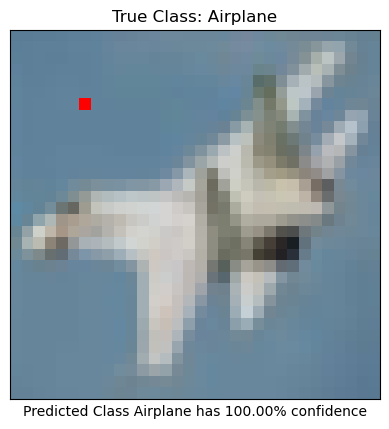

In [63]:
pixel = np.array([6, 6, 255, 0, 0]) 
image_perturbed = perturb_image(pixel, image)[0]

output = torch.softmax(model(image_perturbed[None, ...].to(device)), dim=1)
conf, pred = output.max(dim=1)

fig = plt.figure()
ax = fig.subplots()
ax.imshow(image_perturbed.permute(1,2,0))
ax.set(xticks=[], yticks=[], title=f"True Class: {classes[label]}", xlabel=f"Predicted Class {classes[pred.item()]} has {conf.item()*100:.2f}% confidence")
plt.show()

In [64]:
def attack(image, target, pixel_count=1, maxiter=100, popsize=256):
    
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    popmul = max(1, popsize // len(bounds))
    
    popsize = popmul * len(bounds)
    nc = int(np.sqrt(popsize))
    nr = int(np.ceil(popsize/float(nc)))

    fig = plt.figure(figsize=(nc*4, nr*4))
    axes = fig.subplots(nr, nc)
    for ax, _ in zip(axes.flat, range(popsize)):
        ax.set(title=f"True Class: {classes[label]}")
        ax.set(xlabel=f"Predicted Class {None}\nTrue Class {None} has {None}% condifence")

    for ax in axes.flat:
        ax.set(xticks=[], yticks=[])
        ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    
    fig.tight_layout()
        
    dh = display.display(fig, display_id=True)

    
    def run(perturbations, image, target, evaluate=False):
        images_perturbed = perturb_image(perturbations, image).to(device)
        probabilities = torch.softmax(model(images_perturbed), dim=1)
        prediction = torch.argmax(probabilities, dim=1)
        if evaluate:
            return prediction != target
        else:
            confidence = probabilities[:, target].detach().cpu().numpy()
            
            for i, (ax, image, pred, fitness) in enumerate(zip(axes.flat, images_perturbed.permute(0, 2, 3, 1), prediction, confidence)):
                ax.imshow(image.detach().cpu().numpy())
                ax.set(xlabel=f"Predicted Class {classes[pred.item()]}\nTrue Class {classes[label]} has {fitness*100:.2f}% condifence")

            dh.update(fig) 
            
            return confidence
    
    def predict_fn(xs):
        xs = xs.transpose()
        return run(xs, image, target, evaluate=False)
    
    def callback_fn(x, convergence):
        return run(x, image, target, evaluate=True)

    result = de(
        predict_fn, bounds=bounds, maxiter=maxiter, popsize=popmul, vectorized=True,
        recombination=1, atol=-1, callback=callback_fn, polish=False, disp=True)
    
    return result.x    

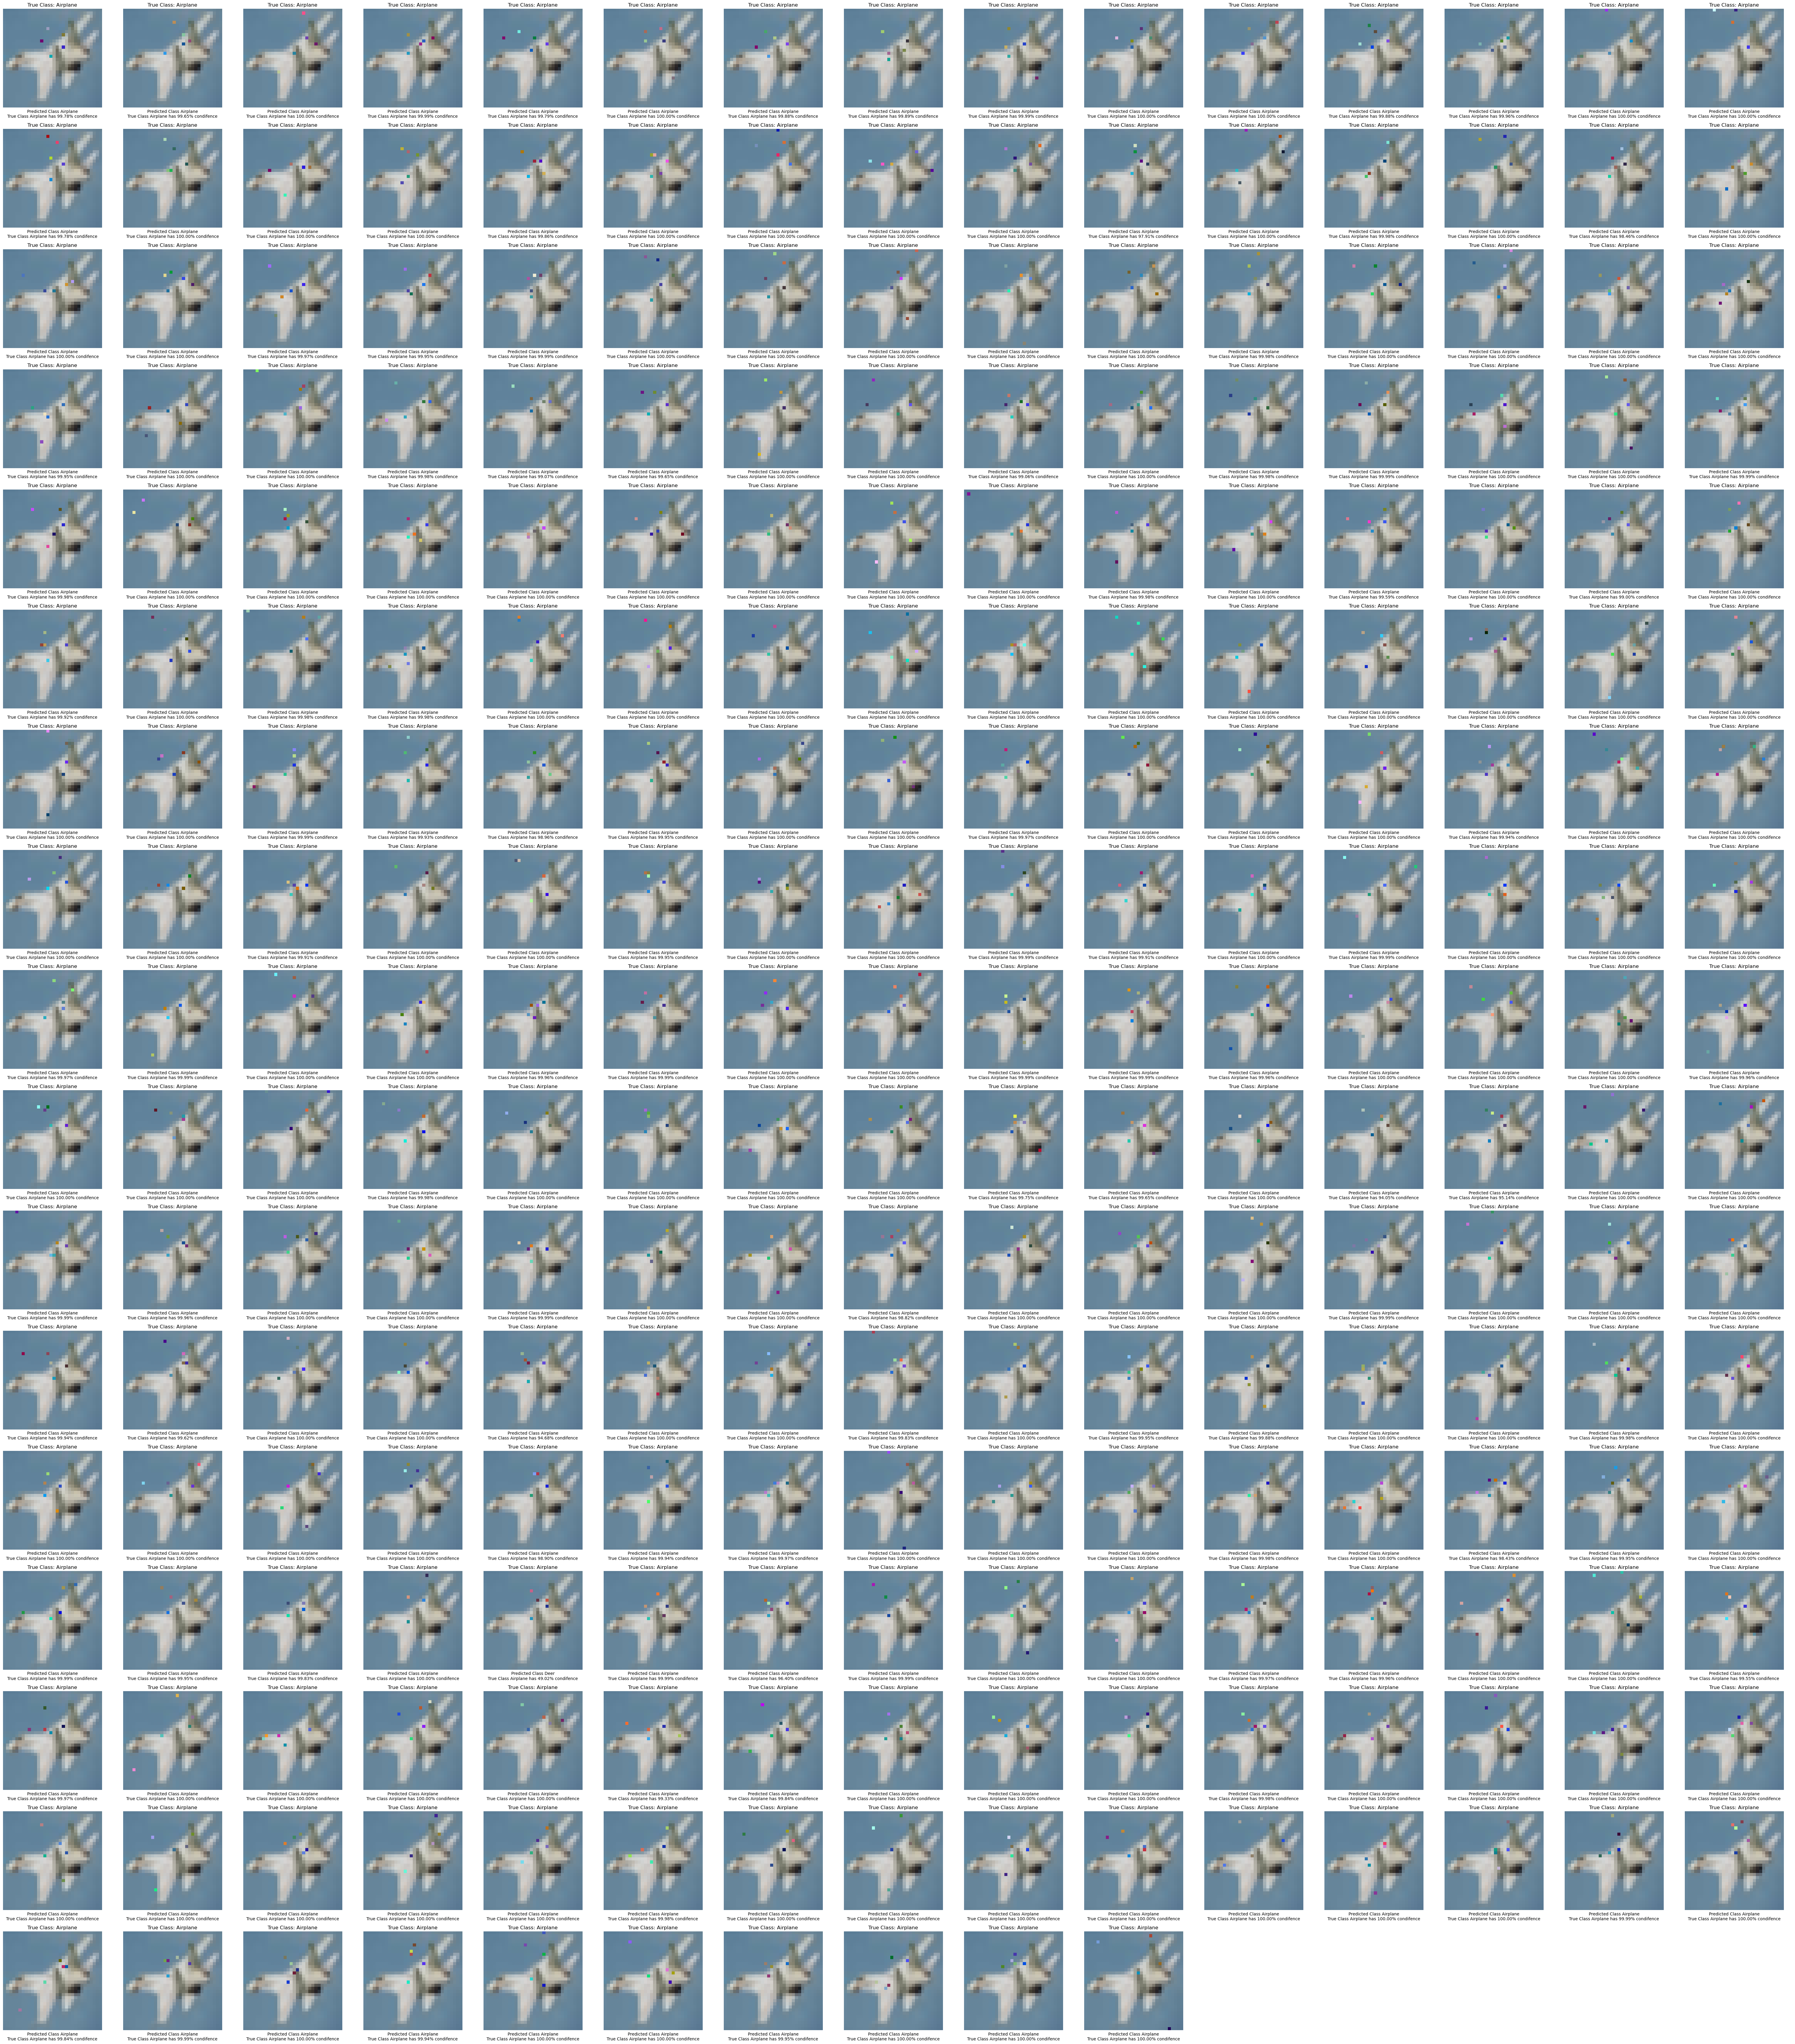

/home/shashank/anaconda3/lib/python3.11/site-packages/scipy/optimize/_differentialevolution.py:387: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 0.999526
differential_evolution step 2: f(x)= 0.999526
differential_evolution step 3: f(x)= 0.999526
differential_evolution step 4: f(x)= 0.999526
differential_evolution step 5: f(x)= 0.999526
differential_evolution step 6: f(x)= 0.999526
differential_evolution step 7: f(x)= 0.999526
differential_evolution step 8: f(x)= 0.999264
differential_evolution step 9: f(x)= 0.999264
differential_evolution step 10: f(x)= 0.999264
differential_evolution step 11: f(x)= 0.999264
differential_evolution step 12: f(x)= 0.999264
differential_evolution step 13: f(x)= 0.998764
differential_evolution step 14: f(x)= 0.990787
differential_evolution step 15: f(x)= 0.990787
differential_evolution step 16: f(x)= 0.990787
differential_evolution step 17: f(x)= 0.990787
differential_evolution step 18: f(x)= 0.990787
differential_evolution step 19: f(x)= 0.990787
differential_evolution step 20: f(x)= 0.990787
differential_evolution step 21: f(x)= 0.990787
differential_evolution

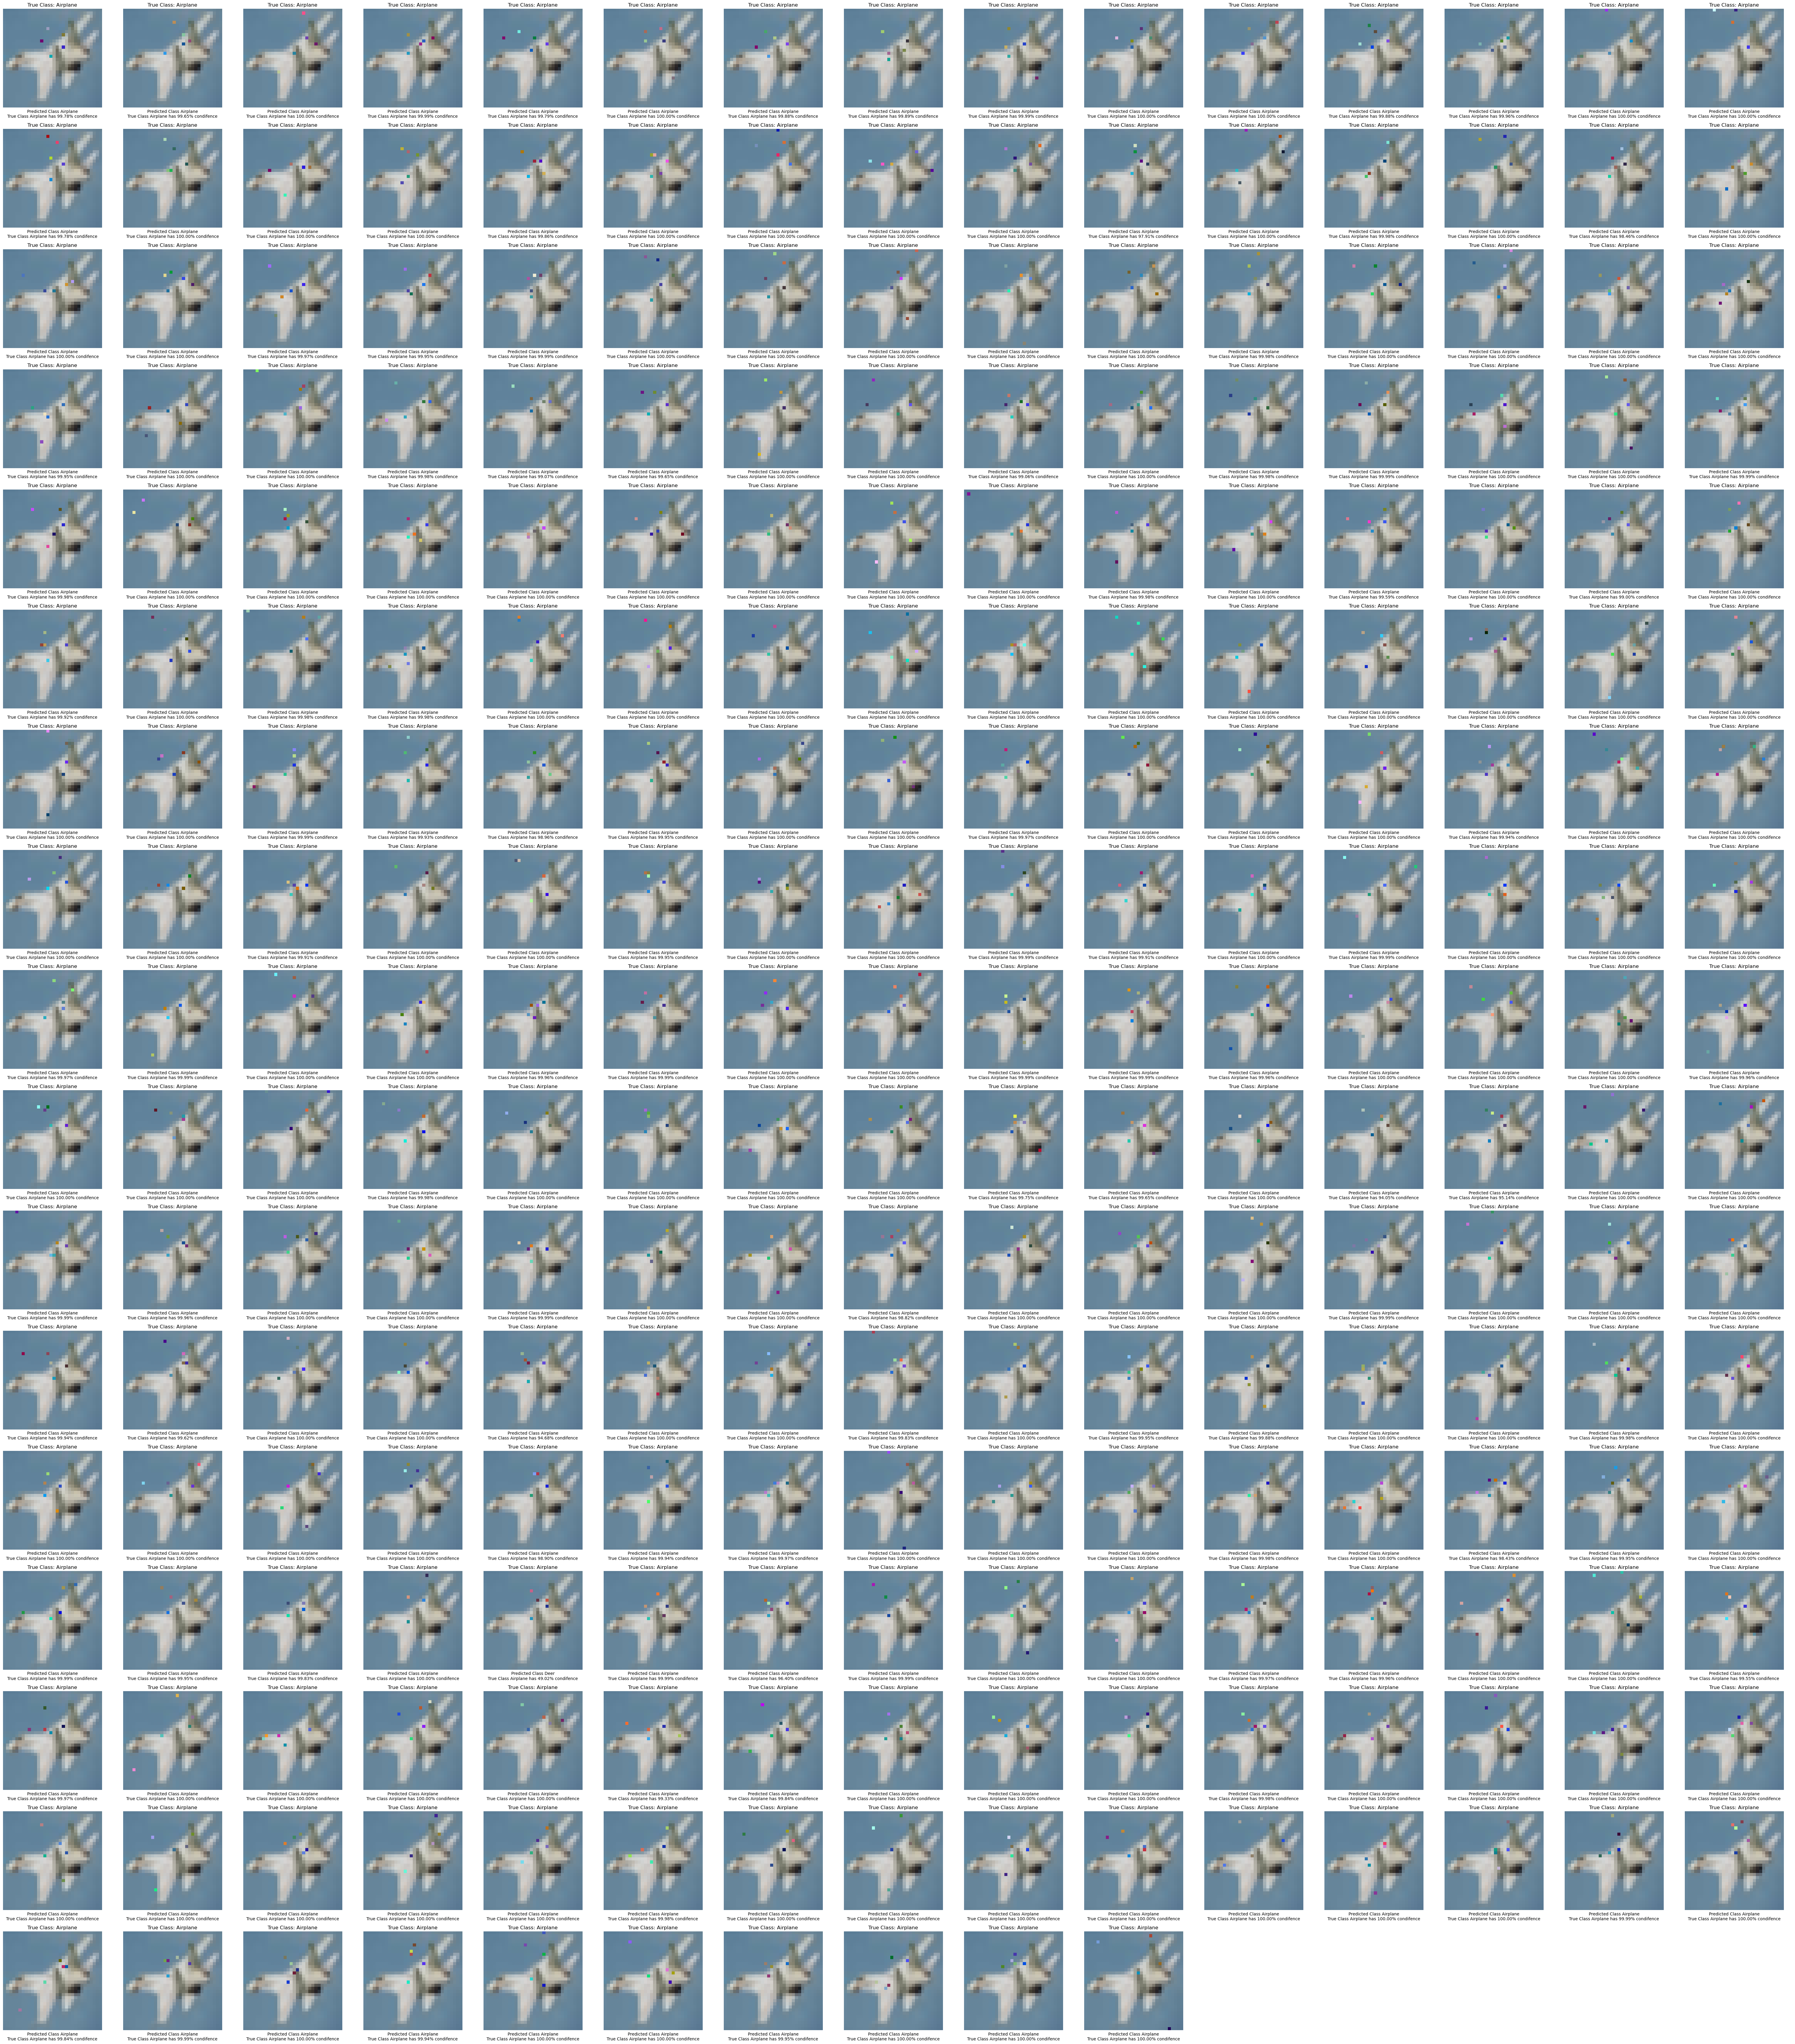

In [65]:
attacked_perturbation = attack(image, label, pixel_count=5)

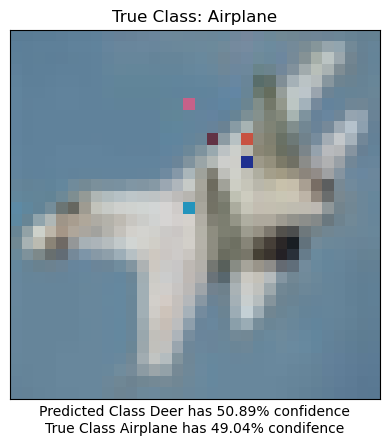

In [66]:
image_perturbed = perturb_image(attacked_perturbation, image)[0]

output = torch.softmax(model(image_perturbed[None, ...].to(device)), dim=1)
conf, pred = output.max(dim=1)
true_conf = output[:, label]

fig = plt.figure()
ax = fig.subplots()
ax.imshow(image_perturbed.permute(1,2,0))
ax.set(xticks=[], yticks=[], title=f"True Class: {classes[label]}", xlabel=f"Predicted Class {classes[pred.item()]} has {conf.item()*100:.2f}% confidence\nTrue Class {classes[label]} has {true_conf.item()*100:.2f}% condifence")
plt.show()